In [17]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
import seaborn as sns
from sklearn.metrics import accuracy_score

# Набор данных

C:\Users\kapgo\AppData\Local\Temp\ipykernel_8528\102690690.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacement_map, inplace=True)


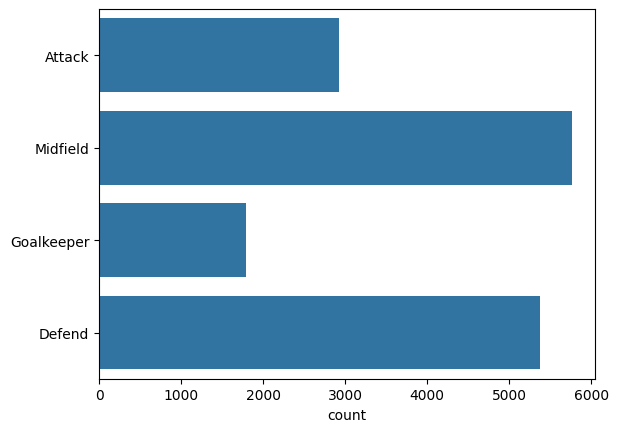

In [18]:
df = pd.read_csv('male_players.csv')
df.drop(columns=['n','Name', 'URL', 'GK', 'Gender', 'Club', 'Nation'], inplace=True)
df = pd.get_dummies(df, columns=['Preferred foot'])
replacement_map = {'Low': 0, 'Medium': 0.5, 'High': 1}
df.replace(replacement_map, inplace=True)
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.dropna(inplace=True)
position_mapping = {
    'CAM': 'Midfield',
    'CB': 'Defend',
    'CDM': 'Midfield',
    'CF': 'Attack',
    'CM': 'Midfield',
    'GK': 'Goalkeeper',
    'LB': 'Defend',
    'LM': 'Midfield',
    'LW': 'Attack',
    'LWB': 'Defend',
    'RB': 'Defend',
    'RM': 'Midfield',
    'RW': 'Attack',
    'RWB': 'Defend',
    'ST': 'Attack'
}
df['Position'] = df['Position'].replace(position_mapping)

X = df.drop('Position', axis=1).to_numpy()
target = df['Position'].to_numpy()

sns.countplot(target)
plt.show()

In [19]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)


In [20]:
np.unique(target)

array(['Attack', 'Defend', 'Goalkeeper', 'Midfield'], dtype=object)

# Расстояние Минковского

$$D = \left( \sum_{i=1}^{n} |x_{i}^{(A)} - x_{i}^{(B)}|^p \right)^{\frac{1}{p}}$$


In [21]:
def minkowski_distance(x1: np.array, x2: np.array, p=2):
    return np.power(np.sum(np.abs(x1 - x2) ** p), 1/p)

# Косинусное расстояние

$$
D = 1 - \frac{A \cdot B}{\|A\| \|B\|}
$$


In [22]:
def cosine_distance(x1, x2):
    dot_product = np.dot(x1, x2)
    norm_x1 = np.linalg.norm(x1)
    norm_x2 = np.linalg.norm(x2)
    cosine_similarity = dot_product / (norm_x1 * norm_x2)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

# Расстояние Чебышева

$$
ρ(a, b) = max_i |a_i - b_i|

$$

In [23]:
def chebyshev_distance(x, y):
    return np.max(np.abs(x - y))   

In [24]:
X_train.shape

(10140, 40)

# Равномерное ядро

$$
Uniform(u) = \frac{1}{2} \cdot [u \lt 1]
$$

In [25]:
def uniform_kernel(u):
    return 0.5 * np.where(np.abs(u) < 1, 1, 0)

# Треугольное ядро

$$
Triangular(u) = (1 - |u|) \cdot [u \lt 1]
$$

In [26]:
def triangular_kernel(u):
    return np.maximum(1 - np.abs(u), 0)

# Ядро Епанечникова

$$
 Epanechnikov(u) = \frac{3}{4} \cdot (1 - u^2) \cdot [u \lt 1]
$$

In [27]:
def epanechnikov_kernel(u):
    return 3/4*(1-u**2)*np.where(np.abs(u) < 1, 1, 0)

# Гауссово ядро

$$
Gaussian(u) = \frac{1}{\sqrt{2\pi}} \cdot exp(\frac{-u^2}{2})
$$

In [28]:
def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u ** 2)

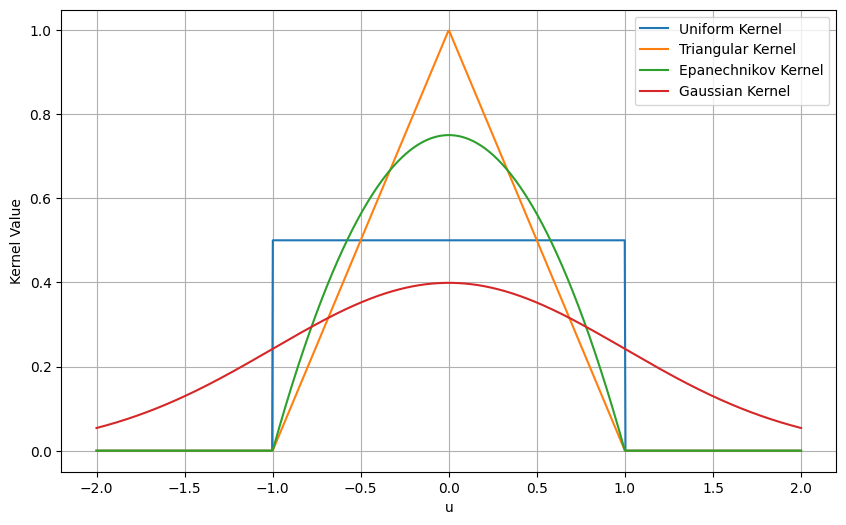

In [29]:
u_values = np.linspace(-2, 2, 1000)

uniform_kernel_values = uniform_kernel(u_values)
triangular_kernel_values = triangular_kernel(u_values)
gaussian_kernel_values = gaussian_kernel(u_values)
epanechnikov_kernel_values = epanechnikov_kernel(u_values)

plt.figure(figsize=(10, 6))
plt.plot(u_values, uniform_kernel_values, label='Uniform Kernel')
plt.plot(u_values, triangular_kernel_values, label='Triangular Kernel')
plt.plot(u_values, epanechnikov_kernel_values, label='Epanechnikov Kernel')
plt.plot(u_values, gaussian_kernel_values, label='Gaussian Kernel')

plt.xlabel('u')
plt.ylabel('Kernel Value')
plt.legend()
plt.grid(True)
plt.show()


# Алгоритм

$$
a(u; D_{\text{train}}) = \arg \max_{y \in Y} \sum_{i=1}^{|D_{\text{train}}|} \left[ y(x_{(u,i)}) = y \right] w_{(i, u)}
$$


# Окно Парзена-Розенблатта с фиксированной шириной окна

$$
a(u; D_{\text{train}}; h; K) = \arg \max_{y \in Y} \sum_{i=1}^{|D_{\text{train}}|} \left[ y(x_{(u,i)}) = y \right] K\left( \frac{\rho(u, x_{(u,i)})}{h} \right)
$$

In [30]:
def fixed_window(u, x, y, h, metric, kernel, aprior_weights):
    classes = np.unique(y)
    classes_count = {c: 0 for c in classes}

    if aprior_weights is None:
        aprior_weights = np.ones(len(x))
    for i in range(len(x)):
        weight = kernel(metric(u, x[i]) / h) * aprior_weights[i]
        classes_count[y[i]] += weight
    return max(classes_count, key=classes_count.get)

# Окно Парзена-Розенблатта с нефиксированной шириной окна

$$
a(u; D_{\text{train}}; k; K) = \arg \max_{y \in Y} \sum_{i=1}^{|D_{\text{train}}|} \left[ y(x_{(u,i)}) = y \right] K\left( \frac{\rho(u, x_{(u,i)})}{\rho(u, x_{(u, k+1)})} \right)
$$


In [31]:
def not_fixed_window(u, x, y, n_neighbors, metric, kernel, aprior_weights):
    classes = np.unique(y)
    classes_count = {c: 0 for c in classes}
    distances = []
    for n in x:
        distances.append(metric(u, n))
    distances.sort()    
    if aprior_weights is None:
        aprior_weights = np.ones(len(x))
    for i in range(len(x)):
        weight = kernel(metric(u, x[i]) / distances[n_neighbors + 1]) * aprior_weights[i]
        classes_count[y[i]] += weight
    return max(classes_count, key=classes_count.get)

In [32]:
def knn_classifier(u, 
                   x, 
                   y, 
                   window="fixed",
                   n_neighbors=5,
                   h=0.1,
                   metric="minkowski_distance",
                   kernel="gaussian_kernel",
                   aprior_weights=None,
                   p=2.0):
    metric_map = {'minkowski_distance'   : lambda x, y: minkowski_distance(x, y, p),
                  'cosine_distance'      : cosine_distance,
                  'chebyshev_distance'   : chebyshev_distance}
    metric = metric_map[metric]
    kernel_map = {'uniform_kernel'      : uniform_kernel,
                  'triangular_kernel'   : triangular_kernel,
                  'epanechnikov_kernel' : epanechnikov_kernel,
                  'gaussian_kernel'     : gaussian_kernel}
    kernel = kernel_map[kernel]
    if window == "fixed":
        return fixed_window(u, x, y, h, metric, kernel, aprior_weights)
    else:
        return not_fixed_window(u, x, y, n_neighbors, metric, kernel, aprior_weights)

# Подбор гиперпараметров

In [33]:
def objective(trial):
    window = trial.suggest_categorical('window', ['fixed', 'not_fixed'])
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    h = trial.suggest_float('h', 0.0001, 1)
    metric = trial.suggest_categorical('metric', ['minkowski_distance', 'cosine_distance'])
    kernel = trial.suggest_categorical('kernel', ['uniform_kernel', 'triangular_kernel', 'epanechnikov_kernel', 'gaussian_kernel'])
    p = trial.suggest_float('p', 0.1, 5.0)
    y_pred = []
    for u in X_valid:
        y_pred.append(knn_classifier(u, X_train, y_train, window, n_neighbors, h, metric, kernel, None, p))
    return accuracy_score(y_pred, y_valid)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print('Best params: ', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2024-03-27 12:52:14,126] A new study created in memory with name: no-name-e91bd609-1c1d-47d2-99c0-057b45da8e92


In [ ]:
def objective(trial):
    n_neighbors = trial.suggest_int("k", 1, 200)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("algorythm", ["ball_tree", "kd_tree", "brute"])
    p = trial.suggest_float("p", 1, 5)
    y_pred = KNeighborsClassifier(n_neighbors, weights=weights, algorithm=algorithm, p=p).fit(X_train, y_train).predict(X_valid)
    return accuracy_score(y_valid, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print('Best params: ', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2024-03-21 00:34:42,585] A new study created in memory with name: no-name-fe130d31-7ab8-4331-ac86-063258021106
[I 2024-03-21 00:34:42,757] Trial 0 finished with value: 0.7875 and parameters: {'k': 152, 'weights': 'distance', 'algorythm': 'brute', 'p': 1.0277609886734793}. Best is trial 0 with value: 0.7875.


[I 2024-03-21 00:34:42,885] Trial 1 finished with value: 0.8125 and parameters: {'k': 106, 'weights': 'distance', 'algorythm': 'ball_tree', 'p': 1.3141113210398778}. Best is trial 1 with value: 0.8125.
[I 2024-03-21 00:34:42,968] Trial 2 finished with value: 0.7625 and parameters: {'k': 140, 'weights': 'distance', 'algorythm': 'kd_tree', 'p': 2.824227679006065}. Best is trial 1 with value: 0.8125.
[I 2024-03-21 00:34:43,052] Trial 3 finished with value: 0.825 and parameters: {'k': 121, 'weights': 'distance', 'algorythm': 'brute', 'p': 2.3312754919076513}. Best is trial 3 with value: 0.825.
[I 2024-03-21 00:34:43,139] Trial 4 finished with value: 0.55 and parameters: {'k': 174, 'weights': 'distance', 'algorythm': 'brute', 'p': 4.921334757316297}. Best is trial 3 with value: 0.825.
[I 2024-03-21 00:34:43,266] Trial 5 finished with value: 0.775 and parameters: {'k': 119, 'weights': 'distance', 'algorythm': 'ball_tree', 'p': 3.7601628843777255}. Best is trial 3 with value: 0.825.
[I 2024-0

Best params:  {'k': 15, 'weights': 'distance', 'algorythm': 'brute', 'p': 1.938973210360973}
Best accuracy:  0.8875


In [ ]:
def calculate_accuracy(x_test, y_test, x_train, y_train, k):
    y_pred = []
    for u in x_test:
        y_pred.append(knn_classifier(u, x_train, y_train, window="not_fixed", n_neighbors=k, metric='minkowski_distance', kernel='epanechnikov_kernel', p=0.25292267947538427))
    return accuracy_score(y_test, y_pred)

my_accuracies_test = []
my_accuracies_valid = []
lib_accuracies_test = []
lib_accuracies_valid = []
for k in range(1, 40):
    my_accuracy_test = calculate_accuracy(X_test, y_test, X_train, y_train, k)
    my_accuracy_valid = calculate_accuracy(X_valid, y_valid, X_train, y_train, k)
    lib_accuracy_test = accuracy_score(KNeighborsClassifier(k, weights='distance', algorithm='brute', p=1.938973210360973).fit(X_train, y_train).predict(X_test), y_test)
    lib_accuracy_valid = accuracy_score(KNeighborsClassifier(k, weights='distance', algorithm='brute', p=1.938973210360973).fit(X_train, y_train).predict(X_valid), y_valid)
    
    my_accuracies_test.append(my_accuracy_test)
    my_accuracies_valid.append(my_accuracies_valid)
    lib_accuracies_test.append(lib_accuracy_test)
    lib_accuracies_valid.append(lib_accuracies_valid)


plt.plot(my_accuracies_test, label="My test")
plt.plot(my_accuracies_valid, label="My valid")
plt.plot(lib_accuracies_test, label="Lib test")
plt.plot(lib_accuracies_valid, label="Lib valid")
plt.xlabel('Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Neighbors')
plt.grid(True)
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
